In [1]:
import numpy as np
import matplotlib.pyplot as plt

This notebook creates an annotated figure of the DA results. IT RELIES on using the "Goldilocks" settings (otherwise we have a different solution and the annotations need to be moved).

In [2]:
np.load('increments.npz').files

['ensX',
 'X_inc',
 't_obs',
 'l_obs',
 't_inc',
 'X_truth',
 'Y_truth',
 't_truth',
 'X_obs']

In [3]:
t_truth = np.load('increments.npz')['t_truth']
X_truth = np.load('increments.npz')['X_truth']
dt = np.diff( t_truth )[0]
t_inc = np.load('increments.npz')['t_inc']
dt_inc = np.diff( t_inc )[0]
da_interval = int( dt_inc/dt )
ensX = np.load('increments.npz')['ensX']
X_inc = np.load('increments.npz')['X_inc']
X_obs = np.load('increments.npz')['X_obs']
l_obs = np.load('increments.npz')['l_obs']

meanX = ensX.mean(axis=-1)
meanXinc = X_inc.mean(axis=-1)

In [4]:
whos

Variable      Type       Data/Info
----------------------------------
X_inc         ndarray    400x8x50: 160000 elems, type `float64`, 1280000 bytes (1.220703125 Mb)
X_obs         ndarray    400x8: 3200 elems, type `float64`, 25600 bytes
X_truth       ndarray    4001x8: 32008 elems, type `float64`, 256064 bytes (250.0625 kb)
da_interval   int        10
dt            float64    0.005
dt_inc        float64    0.05
ensX          ndarray    4001x8x50: 1600400 elems, type `float64`, 12803200 bytes (12.2100830078125 Mb)
l_obs         ndarray    400x8: 3200 elems, type `int32`, 12800 bytes
meanX         ndarray    4001x8: 32008 elems, type `float64`, 256064 bytes (250.0625 kb)
meanXinc      ndarray    400x8: 3200 elems, type `float64`, 25600 bytes
np            module     <module 'numpy' from 'C:\<...>ges\\numpy\\__init__.py'>
plt           module     <module 'matplotlib.pyplo<...>\\matplotlib\\pyplot.py'>
t_inc         ndarray    400: 400 elems, type `float64`, 3200 bytes
t_truth       ndarr

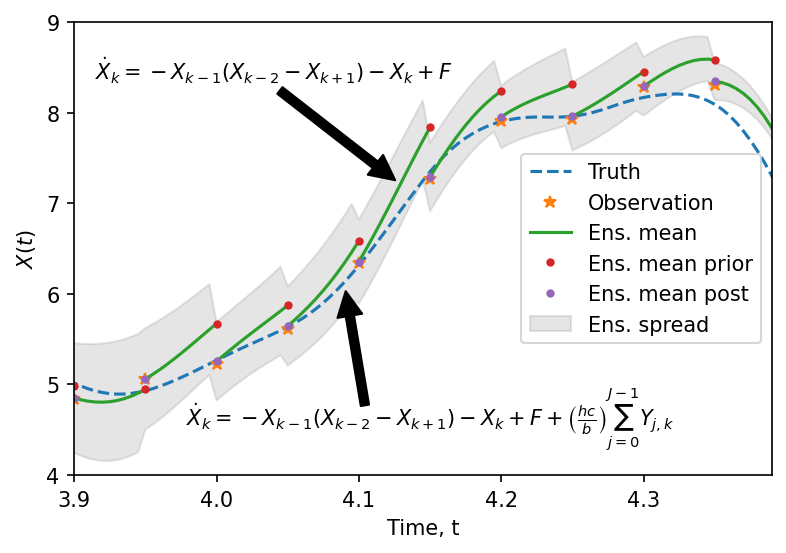

In [5]:
k = 0
nti,K = meanXinc.shape

tt = t_truth[:-1].reshape((t_inc.size,da_interval))
xx = meanX[:-1].reshape((t_inc.size,da_interval,K))
tt = np.column_stack((tt, t_inc))
xx = np.append(xx, (meanX[da_interval::da_interval,:]-meanXinc).reshape((nti,1,K)) ,axis=1)
tt = np.column_stack((tt, t_inc)).flatten()
xx = np.append(xx, np.nan*meanX[da_interval::da_interval,:].reshape((nti,1,K)) ,axis=1)

plt.figure(dpi=150)
# plt.suptitle('Ensemble mean, k = %i'%(k));
plt.plot(t_truth, X_truth[:,k], '--', label='Truth' );
plt.fill_between(t_truth,
                 meanX[:,k]-ensX[:,k,:].std(axis=-1),
                 meanX[:,k]+ensX[:,k,:].std(axis=-1), color='grey', alpha=0.2, label='Ens. spread' );
plt.plot(t_inc, np.take_along_axis(X_obs, np.argsort(l_obs,axis=1), axis=1)[:,k], '*', label='Observation')
plt.plot(tt.flatten(), xx[:,:,k].flatten(), '-', label='Ens. mean' );
plt.plot(t_inc, meanX[da_interval::da_interval,k]-meanXinc[:,k], '.', label='Ens. mean prior' );
plt.plot(t_inc, meanX[da_interval::da_interval,k], '.', label='Ens. mean post')
plt.xlabel('Time, t'); plt.ylabel('$X(t)$'); plt.legend(loc='center right');
plt.xlim(3.9,4.39); plt.ylim(4,9);
plt.text(4.04, 8.3, r'$\dot{X}_k=- X_{k-1} \left( X_{k-2} - X_{k+1} \right) - X_k + F$', ha='center', va='bottom');
plt.gca().annotate('', xytext=(4.04, 8.3), ha='center', va='bottom',
                   xy=(4.13, 7.2), arrowprops=dict(facecolor='black', shrink=0.05) );
plt.text(4.15, 5.0,
         r'$\dot{X}_k=- X_{k-1} \left( X_{k-2} - X_{k+1} \right) - X_k + F + \left( \frac{hc}{b} \right) \sum_{j=0}^{J-1} Y_{j,k}$',
         ha='center', va='top');
plt.gca().annotate('', xytext=(4.105, 4.7), ha='center', va='bottom',
                   xy=(4.09, 6.1), arrowprops=dict(facecolor='black', shrink=0.05) );

At the beginning of a forecast segment, each ensemble member has it's own separation from the ensemble mean, but if the spread is insufficient we artificially "inflate" it.

Each ensemble member is integrated forward solving the model equations, i.e. without the correct coupling term to the $Y$ variables, which the model cannot resolve. The members, and ensemble mean, therefore tend to diverge from the truth.

At the end of each forecast segment, the prior and observation (truth + error) are combined into a posterior. The change is assumed to be representative of the missing coupling term ("missing physics").